In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from tensorflow.keras.applications import resnet50
from keras.models import *
from keras.layers import *
import keras
import warnings
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3, preprocess_input
warnings.filterwarnings('ignore')

In [6]:
# Setting paths and showing the number of images
falciparum = os.listdir("final_dataset1/Falciparum")
falciparum_path = "final_dataset1/Falciparum"
print("Length of falciparum data = ", len(falciparum), 'images')
vivax = os.listdir("final_dataset1/Vivax")
vivax_path = "final_dataset1/Vivax"
print("Length of vivax data = ", len(vivax), 'images')
uninfected = os.listdir("final_dataset1/Uninfected")
uninfected_path = "final_dataset1/Uninfected"
print("Length of uninfected data = ", len(uninfected), 'images')

Length of falciparum data =  965 images
Length of vivax data =  965 images
Length of uninfected data =  965 images


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_shape=(224,224,3)
# Define ImageDataGenerator for both training and validation sets
image_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% of the data will be used for validation
)

# Generate data flow from directory, split into training and validation sets
train_generator = image_gen.flow_from_directory(
    directory='final_dataset1',
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    subset='training',  # Specify training subset
    shuffle=True
)

validation_generator = image_gen.flow_from_directory(
    directory='final_dataset1',
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # Specify validation subset
    shuffle=False
)

Found 2316 images belonging to 3 classes.
Found 579 images belonging to 3 classes.


In [2]:
from tensorflow.keras.applications import ResNet152

# Instantiating the ResNet152 model
resnet152 = ResNet152(input_shape=[224, 224] + [3],
                      weights='imagenet',  # Include the pre-trained weights on ImageNet
                      include_top=False)  # To use our own input and get the desired output

# Do not train the existing weights
for layer in resnet152.layers:
    layer.trainable = False

# Defining input and output to the model
x = Flatten()(resnet152.output)
# Change the number of neurons in the output layer to 3 for 3 classes and use 'softmax' activation
prediction = Dense(3, activation='softmax')(x)

# Creating a model
model = Model(inputs=resnet152.input, outputs=prediction)

# Compiling the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Print model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block6_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block6_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block6_2_relu[0][0]']    
                                                                                                  
 conv3_block6_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block6_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 14, 14, 1024  525312      ['conv3_block8_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
          

                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block4_2_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block7_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block7_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block10_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block10_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block10_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block10_1_relu[0][0]']   
                                                                                                  
 conv4_block10_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block10_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block10_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block10_2_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block13_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block13_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block13_1_relu[0][0]']   
                                                                                                  
 conv4_block13_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block13_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block13_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block13_2_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block16_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block16_1_relu[0][0]']   
                                                                                                  
 conv4_block16_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block16_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block19_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block19_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block19_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block19_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block19_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block19_1_relu[0][0]']   
                                                                                                  
 conv4_block19_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block19_2_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block22_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block22_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block22_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block22_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block22_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block22_1_relu[0][0]']   
                                                                                                  
 conv4_block22_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block22_2_conv[0][0]']   
 lization)

 conv4_block25_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block24_out[0][0]']      
                                                                                                  
 conv4_block25_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block25_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block25_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block25_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block25_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block25_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block28_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block27_out[0][0]']      
                                                                                                  
 conv4_block28_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block28_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block28_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block28_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block28_1_relu[0][0]']   
          

                                )                                                                 
                                                                                                  
 conv4_block31_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block30_out[0][0]']      
                                                                                                  
 conv4_block31_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block31_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block31_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block31_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block33_out (Activation)  (None, 14, 14, 1024  0          ['conv4_block33_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block34_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block33_out[0][0]']      
                                                                                                  
 conv4_block34_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block34_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block34_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block34_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block36_out (Activation)  (None, 14, 14, 1024  0          ['conv4_block36_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 512)    524800      ['conv4_block36_out[0][0]']      
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)       

                                                                  'conv5_block3_3_bn[0][0]']      
                                                                                                  
 conv5_block3_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block3_add[0][0]']       
                                                                                                  
 flatten (Flatten)              (None, 100352)       0           ['conv5_block3_out[0][0]']       
                                                                                                  
 dense (Dense)                  (None, 3)            301059      ['flatten[0][0]']                
                                                                                                  
Total params: 58,672,003
Trainable params: 301,059
Non-trainable params: 58,370,944
__________________________________________________________________________________________________


In [11]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)


Epoch 1/10
73/73 [==============================] - 1332s 18s/step - loss: 1.5331 - accuracy: 0.7098 - val_loss: 1.2404 - val_accuracy: 0.7668
Epoch 2/10
73/73 [==============================] - 738s 10s/step - loss: 0.4931 - accuracy: 0.8359 - val_loss: 0.3852 - val_accuracy: 0.8377
Epoch 3/10
73/73 [==============================] - 901s 12s/step - loss: 0.3078 - accuracy: 0.8921 - val_loss: 0.4653 - val_accuracy: 0.8342
Epoch 4/10
73/73 [==============================] - 734s 10s/step - loss: 0.2228 - accuracy: 0.9145 - val_loss: 0.2952 - val_accuracy: 0.9016
Epoch 5/10
73/73 [==============================] - 729s 10s/step - loss: 0.2479 - accuracy: 0.9067 - val_loss: 0.1375 - val_accuracy: 0.9499
Epoch 6/10
73/73 [==============================] - 2635s 36s/step - loss: 0.2183 - accuracy: 0.9249 - val_loss: 0.5305 - val_accuracy: 0.8273
Epoch 7/10
73/73 [==============================] - 1880s 26s/step - loss: 0.2644 - accuracy: 0.9123 - val_loss: 0.1475 - val_accuracy: 0.9465
Epo

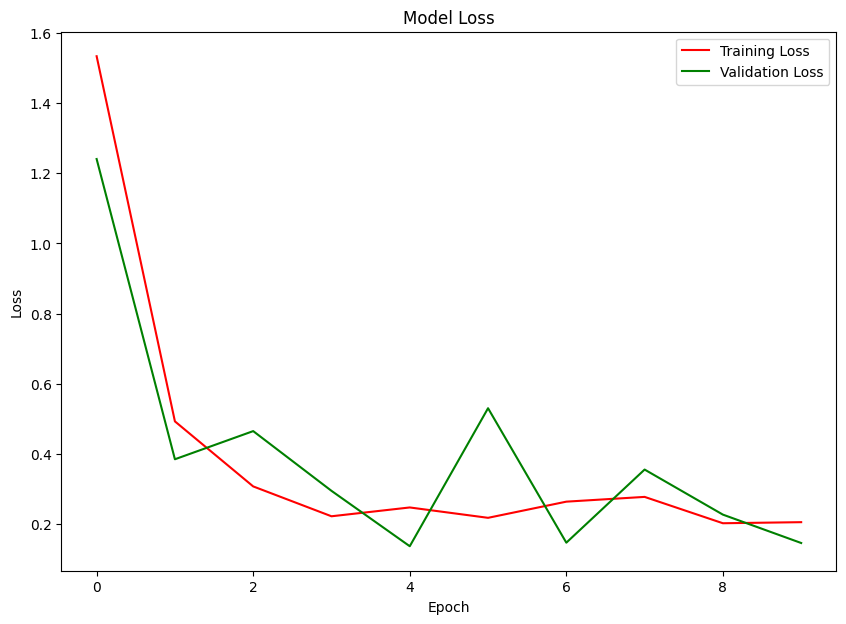

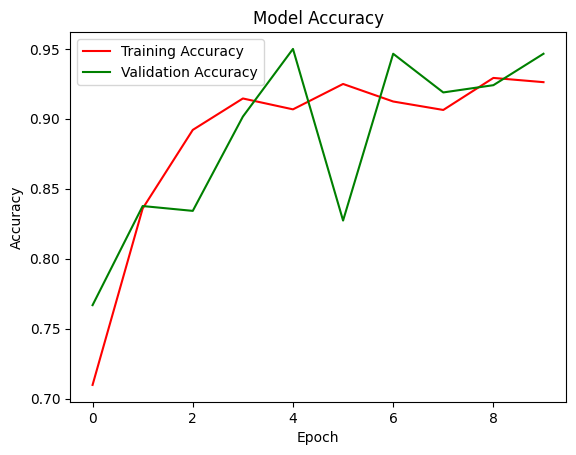

In [12]:
# Create a new figure and axes object
fig, ax = plt.subplots(figsize=(10, 7))

# Check if 'loss' and 'val_loss' are in history.history
if 'loss' in history.history:
    ax.plot(history.history['loss'], color='red', label='Training Loss')
if 'val_loss' in history.history:
    ax.plot(history.history['val_loss'], color='green', label='Validation Loss')

# Add labels and legend
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

# Show plot
plt.show()

if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], color='red', label='Training Accuracy')

# Plot validation accuracy
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], color='green', label='Validation Accuracy')

# Add labels and legend
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()



# With PreProcessing


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_shape=(224,224,3)
# Define ImageDataGenerator for both training and validation sets
image_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% of the data will be used for validation
)

# Generate data flow from directory, split into training and validation sets
train_generator = image_gen.flow_from_directory(
    directory='preprocessed_dataset',
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    subset='training',  # Specify training subset
    shuffle=True
)

validation_generator = image_gen.flow_from_directory(
    directory='preprocessed_dataset',
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # Specify validation subset
    shuffle=False
)

Found 2316 images belonging to 3 classes.
Found 579 images belonging to 3 classes.


In [4]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)


Epoch 1/10
73/73 [==============================] - 765s 10s/step - loss: 1.1326 - accuracy: 0.7185 - val_loss: 0.1641 - val_accuracy: 0.9672
Epoch 2/10
73/73 [==============================] - 736s 10s/step - loss: 0.1967 - accuracy: 0.9292 - val_loss: 0.1975 - val_accuracy: 0.9154
Epoch 3/10
73/73 [==============================] - 750s 10s/step - loss: 0.1515 - accuracy: 0.9404 - val_loss: 0.2439 - val_accuracy: 0.8895
Epoch 4/10
73/73 [==============================] - 741s 10s/step - loss: 0.1686 - accuracy: 0.9309 - val_loss: 0.1179 - val_accuracy: 0.9447
Epoch 5/10
73/73 [==============================] - 1192s 16s/step - loss: 0.1352 - accuracy: 0.9465 - val_loss: 0.0935 - val_accuracy: 0.9724
Epoch 6/10
73/73 [==============================] - 741s 10s/step - loss: 0.1231 - accuracy: 0.9551 - val_loss: 0.1314 - val_accuracy: 0.9465
Epoch 7/10
73/73 [==============================] - 754s 10s/step - loss: 0.1993 - accuracy: 0.9249 - val_loss: 0.3217 - val_accuracy: 0.8791
Epoch

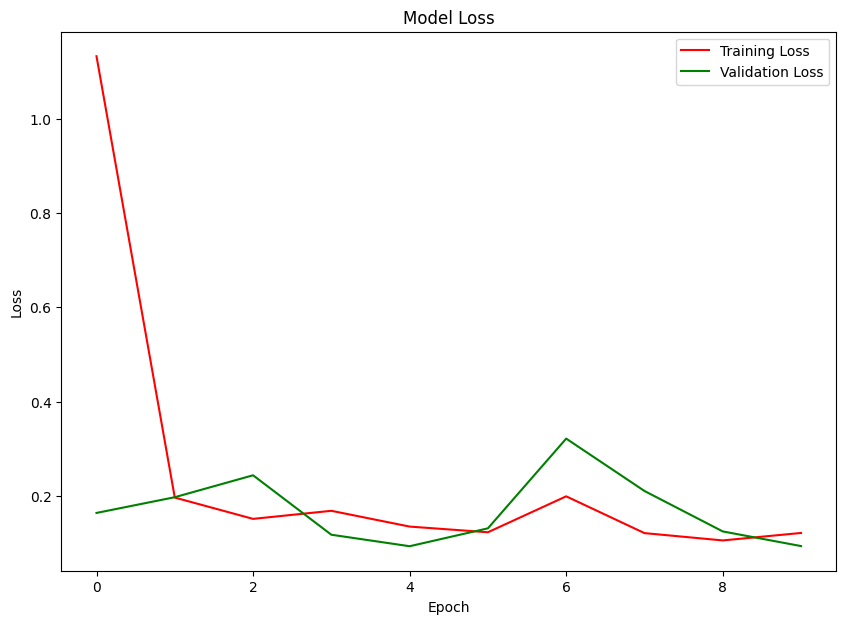

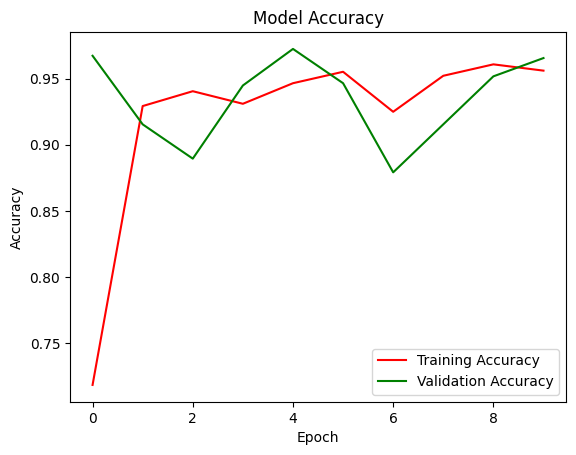

In [5]:
# Create a new figure and axes object
fig, ax = plt.subplots(figsize=(10, 7))

# Check if 'loss' and 'val_loss' are in history.history
if 'loss' in history.history:
    ax.plot(history.history['loss'], color='red', label='Training Loss')
if 'val_loss' in history.history:
    ax.plot(history.history['val_loss'], color='green', label='Validation Loss')

# Add labels and legend
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

# Show plot
plt.show()

if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], color='red', label='Training Accuracy')

# Plot validation accuracy
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], color='green', label='Validation Accuracy')

# Add labels and legend
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
